In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
figSize = (8, 6)

# Read Data
#Config = ("SumE", "NHits","RecoE_cheat")
Config = ("SumE", "NHits","RecoE_MLP0","RecoE_MLP1")
#Config = ("SumE", "RecoE_MLP_GELU","RecoE_MLP_Softsign","RecoE_MLP_Res_PReLU")
#Config = ("SumE","NHits","RecoE_MLP","RecoE_MLP_BasicPerformance")
#Config = ("RecoE_MLP_MSE","RecoE_MLP_RelativeMSE","RecoE_MLP_Huber")
#Config = ("SumE","NHits","RecoE_MLP_Layer[64,32,16,8]")
#Config = ("SumE", "NHits")
colors = ['blue', 'green', 'red','orange','purple']
dataPath = "/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Reco_Results"

particleEnergy = []
meanGamma = []
meanGammaErr = []
peakGamma = []
peakGammaErr = []
resGamma = []
resGammaErr = []

for i_config in range(len(Config)):
    fileName = os.path.join(dataPath, f"{Config[i_config]}_Fit.csv")
    df = pd.read_csv(fileName)
    particleEnergy.append(df["ParticleEnergy"].to_numpy())
    meanGamma.append(df["Mean_Gamma"].to_numpy())
    meanGammaErr.append(df["Mean_Gamma_Error"].to_numpy())
    peakGamma.append(df["Peak_Gamma"].to_numpy())
    peakGammaErr.append(df["Peak_Gamma_Error"].to_numpy())
    resGamma.append(df["Res_Gamma"].to_numpy())
    resGammaErr.append(df["Res_Gamma_Error"].to_numpy())
    print(f"Loaded {fileName}")


Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Reco_Results/SumE_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Reco_Results/NHits_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Reco_Results/RecoE_MLP2_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Reco_Results/RecoE_MLP1_Fit.csv


Config: SumE
Config: NHits
Config: RecoE_MLP2
Config: RecoE_MLP1


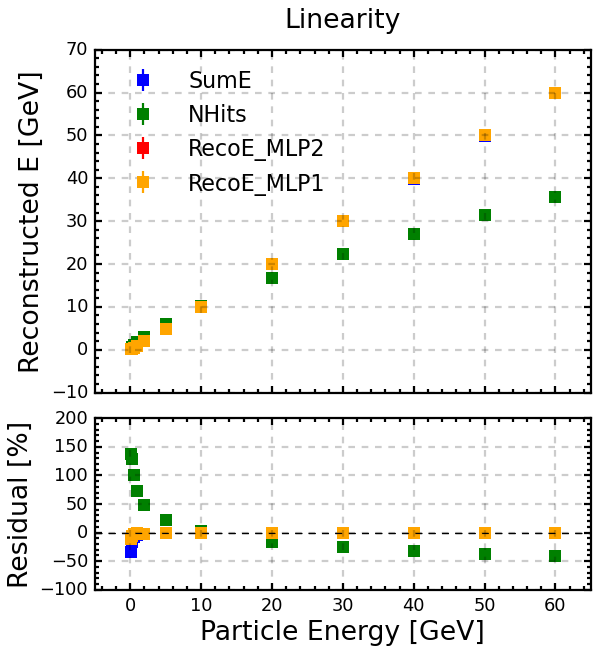

Config: SumE
Config: NHits
Config: RecoE_MLP2
Config: RecoE_MLP1


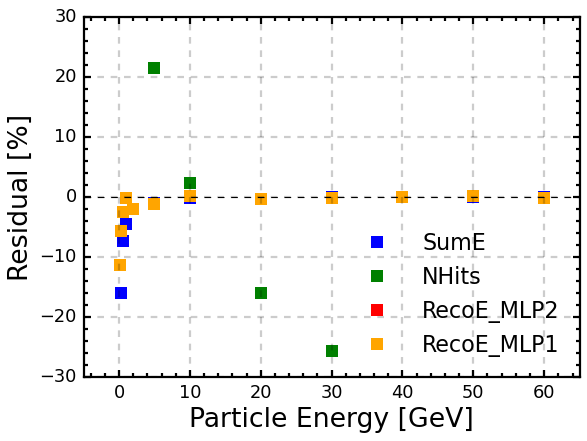

In [57]:

# Linearity and Resolution
def linear_func(x, a, b):
    return a * x + b

def fitAndResidualRatio(x, y, fit_range=(0,70)):
    """Linear fit and return coefficients, fit values, and relative residuals."""
    a0 = (y[-1] - y[0]) / (x[-1] - x[0])
    b0 = y[0]
    p0 = [a0, b0]
    upper_bound = [5*a0, np.inf]
    lower_bound = [0, -np.inf]  # Ensure slope is non-negative
    mask = (x >= fit_range[0]) & (x <= fit_range[1])
    coeffs, cov = curve_fit(linear_func, x[mask], y[mask], p0=p0, bounds=(lower_bound, upper_bound))
    fitVals = linear_func(x, *coeffs)
    residualRatio = (y - fitVals) / fitVals
    return coeffs, fitVals, residualRatio
fitGamma,ResGamma = [],[]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figSize[0], figSize[1]*1.5), 
        sharex=True,gridspec_kw={'height_ratios':[1, 0.5],'hspace': 0.1})
MarkerSize = 10
for i_c in range(len(Config)):
    print(f"Config: {Config[i_c]}")
    if Config[i_c] == "NHits":
        fit_range = (0, 10)
    else:
        fit_range = (0, 70)
    #Calib
    coeff,fitVals,residualRatio = fitAndResidualRatio(particleEnergy[i_c], peakGamma[i_c], fit_range=fit_range)
    peakGamma[i_c] = (peakGamma[i_c])/(coeff[0])
    peakGammaErr[i_c] = peakGammaErr[i_c]/(coeff[0])
    coeff,fitVals,residualRatio = fitAndResidualRatio(particleEnergy[i_c], peakGamma[i_c], fit_range=fit_range)
    residualRatio = (peakGamma[i_c] - particleEnergy[i_c]) / particleEnergy[i_c]
    fitGamma.append(fitVals)
    ResGamma.append(residualRatio)
    # Gamma
    ax1.errorbar(particleEnergy[i_c], peakGamma[i_c], yerr=peakGammaErr[i_c],
        fmt='s', capsize=4, label=Config[i_c], color=colors[i_c], markersize=MarkerSize
    )
    #ax1.plot(particleEnergy[i_c], fitGamma[i_c], '-', color=colors[i_c])
    ax1.set_ylabel("Reconstructed E [GeV]")
    #ax1.set_ylim(-100, 1300)
    ax1.set_xlim(-5, 65)
    ax1.set_title("Linearity")
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.2)

    ax2.plot(particleEnergy[i_c], ResGamma[i_c]*100, 's', label='Gamma', color=colors[i_c],markersize=MarkerSize)

    ax2.axhline(0, color='black', lw=1, linestyle='--')
    ax2.set_xlabel("Particle Energy [GeV]")
    ax2.set_ylabel("Residual [%]")
    ax2.grid(True, linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=figSize)

for i_c in range(len(Config)):
    print(f"Config: {Config[i_c]}")
    # 假设 fitGamma 和 ResGamma 已经计算好
    plt.plot(particleEnergy[i_c], ResGamma[i_c]*100, 's', label=Config[i_c], 
             color=colors[i_c], markersize=MarkerSize)

plt.axhline(0, color='black', lw=1, linestyle='--')
plt.xlabel("Particle Energy [GeV]")
plt.ylabel("Residual [%]")
plt.xlim(-5, 65)
plt.ylim(-30, 30)
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend(loc='lower right')
plt.show()


/tmp/ipykernel_3453227/3124738620.py:6: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(E)


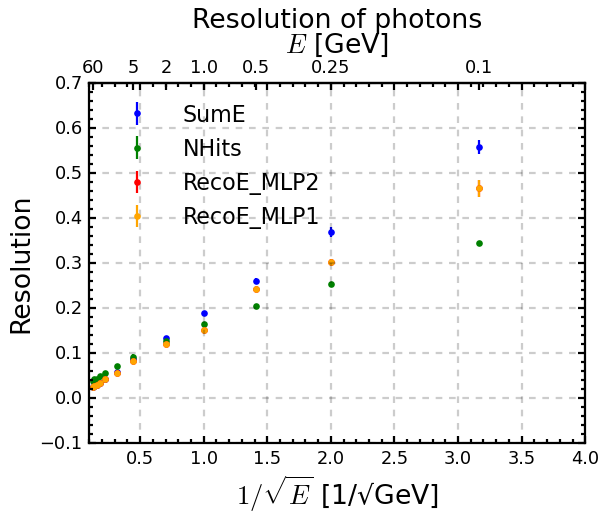

In [58]:
plt.figure(figsize=figSize)
ax = plt.gca()
def forward(x):  # 下轴(1/sqrt(E)) -> 上轴(E)
    return 1 / (x**2)
def inverse(E):  # 上轴(E) -> 下轴(1/sqrt(E))
    return 1 / np.sqrt(E)
secax = ax.secondary_xaxis("top", functions=(forward, inverse))
secax.set_xlabel(r"$E$ [GeV]")
E_ticks = [0.1, 0.25, 0.5, 1.0, 2, 5, 60]
secax.set_xticks(E_ticks)
secax.set_xticklabels(E_ticks)
secax.xaxis.set_minor_locator(plt.NullLocator())  # 禁用所有次刻度
secax.xaxis.set_tick_params(which='both', top=True, labeltop=True, bottom=False, labelbottom=False)
for i_c in range(len(Config)):
    x_vals = 1 / np.sqrt(particleEnergy[i_c])
    ax.errorbar(x_vals, resGamma[i_c], yerr=resGammaErr[i_c],
                fmt='o', capsize=4, label=Config[i_c], color=colors[i_c])
ax.set_xlabel(r"$1/\sqrt{E}$ [1/√GeV]")
ax.set_ylabel("Resolution")
ax.set_title("Resolution of photons", pad=50)
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_xlim(0.1, 4)
plt.show()

    